## Calculating return period for cyclones in Mozambique

We're looking to calculate the return period for cyclones of a given threshold speed over select provinces in Mozambique. We'd like to have both: 
- An overall return period across all selected provinces
- A per-province return period

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [25]:
import geopandas as gpd
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from shapely.geometry import LineString
from datetime import datetime
import matplotlib.pyplot as plt
from src.constants import *
from src.datasources import helpers

load_dotenv()
# https://en.wikipedia.org/wiki/Tropical_cyclone_scales#South-West_Indian_Ocean

False

## 1. Data loading and preparation

We'll start by loading in the required data sources below. We need the ADM1 boundaries (provinces) and the [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive) `.shp` of cyclone tracks. We'll select only the provinces of interest from the admin boundaries file.

In [2]:
gdf_adm0 = codab.load_codab(admin_level=0)
gdf_adm1 = codab.load_codab(admin_level=1)
gdf_adm2 = codab.load_codab(admin_level=2)

gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
gdf_adm2_sel = gdf_adm2[gdf_adm2.ADM2_PT.isin(ADMS2)]
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
lines_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.lines/IBTrACS.SI.list.v04r01.lines.shp"
)

gdf_points = gpd.read_file(points_path)
gdf_lines = gpd.read_file(lines_path)

In [4]:
# Some additional data shared from Tristan that might be useful
wmo_speeds_path = (
    Path(AA_DATA_DIR_NEW)
    / "public"
    / "processed"
    / "glb"
    / "ibtracs"
    / "ibtracs_with_wmo_wind.parquet"
)
df_wmo_speeds = pd.read_parquet(wmo_speeds_path)

Let's also check that both datasets have the same CRS. Then we can select only the points within the polygons. We'll also clean up the columns and make sure points are sorted by time.

In [5]:
assert gdf_points.crs == gdf_sel.crs == gdf_lines.crs
gdf_points_sel = gpd.sjoin(
    gdf_points, gdf_sel, how="inner", predicate="intersects"
)
gdf_points_sel_ = gdf_points_sel[
    [
        "ADM1_PT",
        "NAME",
        "ISO_TIME",
        "REU_WIND",
        "WMO_WIND",
        "USA_WIND",
        "geometry",
    ]
].sort_values("ISO_TIME")
gdf_points_adm0 = gpd.sjoin(
    gdf_points, gdf_adm0, how="inner", predicate="intersects"
)
gdf_points_adm1 = gpd.sjoin(
    gdf_points, gdf_adm1, how="inner", predicate="intersects"
)

In [28]:
gdf_points_adm0[gdf_points_adm0["REU_WIND"] >= 64]["NAME"].unique()

array(['ANGELE', 'ELINE:LEONE', 'HUDAH', 'JAPHET', 'FAVIO', 'JOKWE',
       'DINEO', 'IDAI', 'KENNETH', 'ELOISE'], dtype=object)

In [30]:
gdf_points_adm0[gdf_points_adm0["NAME"] == "FREDDY"]["REU_WIND"].unique()

array([nan])

In [31]:
gdf_points_adm0[gdf_points_adm0["NAME"] == "GOMBE"]["REU_WIND"].unique()

array([nan])

In [32]:
gdf_points_adm0[gdf_points_adm0["NAME"] == "ANA"]["REU_WIND"].unique()

array([nan])

<Axes: >

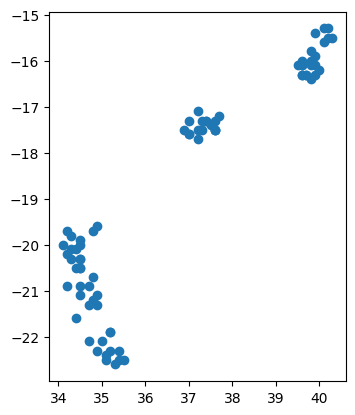

In [5]:
gdf_adm2_points = gpd.sjoin(
    gdf_points, gdf_adm2_sel, how="inner", predicate="intersects"
)
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_adm2_points.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

And plot for a basic sanity check

<Axes: >

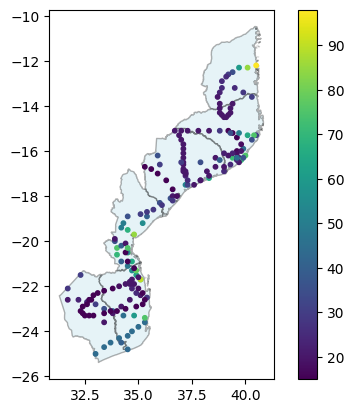

In [7]:
ax = gdf_sel.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

<Axes: >

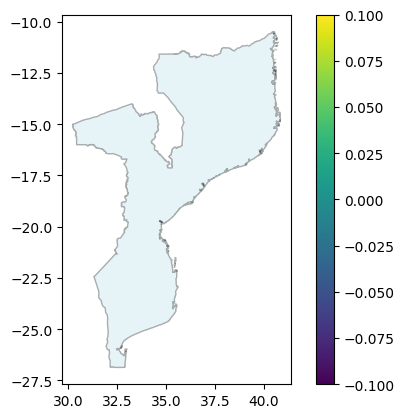

In [ ]:
# plotting Freddy
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points[gdf_points["NAME"] == "FREDDY"].plot(
    ax=ax, column="REU_WIND", markersize=10, legend=True
)

In [8]:
## 2. Return period calculation

How often do storms reach 80km/hr within these provinces?

In [7]:
# combining US Wind and REUnion for those with no wind speed
gdf_points_adm1["REU_USA_WIND"] = gdf_points_adm1["REU_WIND"].fillna(
    gdf_points_adm1["USA_WIND"] * 0.88
)
# combining US Wind and REUnion for those with no wind speed
gdf_points_sel_["REU_USA_WIND"] = gdf_points_sel_["REU_WIND"].fillna(
    gdf_points_sel_["USA_WIND"] * 0.88
)
# combining US Wind and REUnion for those with no wind speed
gdf_adm2_points["REU_USA_WIND"] = gdf_adm2_points["REU_WIND"].fillna(
    gdf_adm2_points["USA_WIND"] * 0.88
)

In [9]:
gdf_points_adm1["ADM1_PT"].unique()

array(['Cabo Delgado', 'Nampula', 'Zambezia', 'Sofala', 'Manica',
       'Inhambane', 'Gaza', 'Niassa', 'Maputo', 'Tete'], dtype=object)

C:\Users\pauni\AppData\Local\Temp\ipykernel_56860\2582961120.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


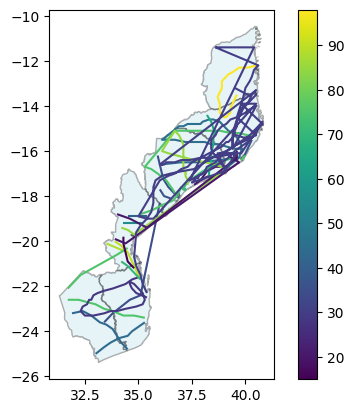

In [9]:
# Plotting the map with enhancements
fig, ax = plt.subplots(figsize=(12, 10))

# Plot ADM0 layer (country boundary)
gdf_adm0.plot(
    ax=ax,
    color="lightblue",
    edgecolor="black",
    alpha=0.3,
    label="Mozambique Boundary",
)

# Plot ADM1 layer (province boundaries)
gdf_adm1.plot(
    ax=ax, color="none", edgecolor="black", linewidth=0.8, label="Provinces"
)

# Plot storm points with color based on REU_USA_WIND values
storm_plot = gdf_points_adm1.plot(
    ax=ax,
    column="REU_USA_WIND",
    cmap="coolwarm",  # Gradient colormap for storm intensities
    markersize=30,
    legend=True,
    alpha=0.8,
    zorder=3,  # Ensures points are on top
)

# Add title
ax.set_title("IBTrACS: Storms in Mozambique", fontsize=16, pad=20)

# Add a legend for boundaries
handles, labels = ax.get_legend_handles_labels()
boundary_legend = [
    plt.Line2D(
        [0],
        [0],
        color="lightblue",
        lw=8,
        alpha=0.3,
        label="Mozambique Boundary",
    ),
    plt.Line2D([0], [0], color="black", lw=1, label="Province Boundaries"),
]
ax.legend(handles=boundary_legend, fontsize=10, loc="lower right")

# Adjust legend for storm intensity
cbar = storm_plot.get_figure().get_axes()[-1]
cbar.set_title("Wind Speed\n(knots)", fontsize=10)

# Adjust grid and axis
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

# Improve layout
plt.tight_layout()
plt.show()

In [10]:
storm_max_wind = (
    gdf_points_adm1.groupby(["ADM1_PT", "NAME"])["REU_USA_WIND"]
    .max()
    .reset_index()
)

# Create columns to track if max wind speed exceeds thresholds
storm_max_wind["severe_tropical_storm"] = storm_max_wind["REU_USA_WIND"] >= 48
storm_max_wind["tropical_cyclone"] = storm_max_wind["REU_USA_WIND"] >= 64

# Group by province and count the number of storms above the thresholds
storm_counts = (
    storm_max_wind.groupby("ADM1_PT")
    .agg(
        severe_tropical_storms=("severe_tropical_storm", "sum"),
        tropical_cyclones=("tropical_cyclone", "sum"),
    )
    .reset_index()
)
storm_counts

,ADM1_PT,severe_tropical_storms,tropical_cyclones
0,Cabo Delgado,1,1
1,Gaza,0,0
2,Inhambane,3,3
3,Manica,1,0
4,Maputo,0,0
5,Nampula,4,4
6,Niassa,0,0
7,Sofala,8,4
8,Tete,0,0
9,Zambezia,4,3


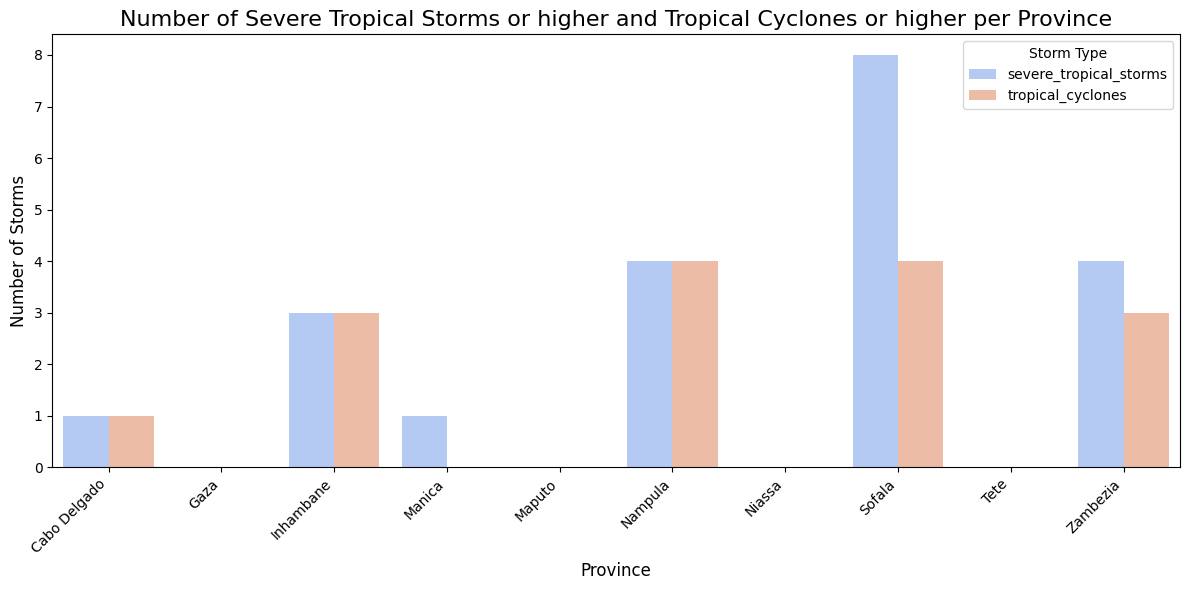

In [10]:
plt.figure(figsize=(12, 6))

# Create a barplot using seaborn
sns.barplot(
    data=storm_counts.melt(
        id_vars="ADM1_PT",
        value_vars=["severe_tropical_storms", "tropical_cyclones"],
        var_name="Storm Type",
        value_name="Count",
    ),
    x="ADM1_PT",
    y="Count",
    hue="Storm Type",
    palette="coolwarm",
)

# Title and labels
plt.title(
    "Number of Severe Tropical Storms or higher and Tropical Cyclones or higher per Province",
    fontsize=16,
)
plt.xlabel("Province", fontsize=12)
plt.ylabel("Number of Storms", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Ensure y-axis is in integer format
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Show the legend and the plot
plt.legend(title="Storm Type", fontsize=10)
plt.tight_layout()
plt.show()

In [12]:
df = gdf_points_sel_[
    gdf_points_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1990
]
df["NAME"].unique()

array(['NADIA', 'FODAH', 'BONITA', 'LISETTE', 'UNNAMED', 'BELTANE',
       'ASTRIDE', 'ELINE:LEONE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       'FAVIO', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA', 'HARUNA', 'DELIWE',
       'GUITO', 'HELLEN', 'CHEDZA', 'DINEO', 'DESMOND', 'IDAI', 'KENNETH',
       'CHALANE', 'ELOISE', 'GUAMBE', 'ANA', 'GOMBE', 'JASMINE', 'FREDDY',
       'FILIPO'], dtype=object)

In [13]:
df_adm2 = gdf_adm2_points[
    gdf_adm2_points["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1980
]
df_adm2["NAME"].unique()

array(['ELECTRE', 'LISETTE', 'UNNAMED', 'ELINE:LEONE', 'DELFINA',
       'JAPHET', 'FAVIO', 'JOKWE', 'IZILDA', 'DELIWE', 'HELLEN', 'CHEDZA',
       'DESMOND', 'IDAI', 'ELOISE', 'GUAMBE', 'ANA', 'GOMBE', 'JASMINE',
       'FREDDY', 'DIKELEDI'], dtype=object)

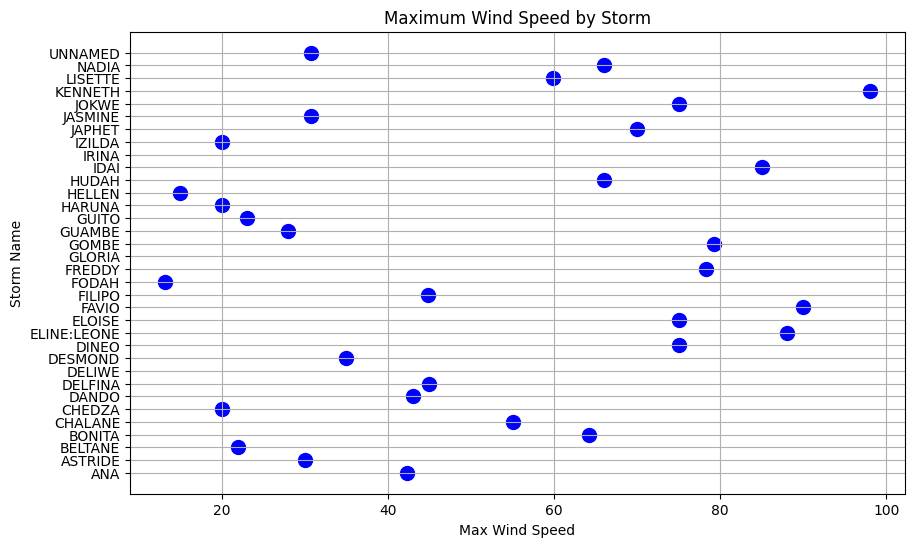

In [14]:
max_values = df.groupby("NAME")["REU_USA_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 6))
plt.scatter(
    max_values["REU_USA_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title("Maximum Wind Speed by Storm just after Landfall")
plt.grid(True)
plt.show()

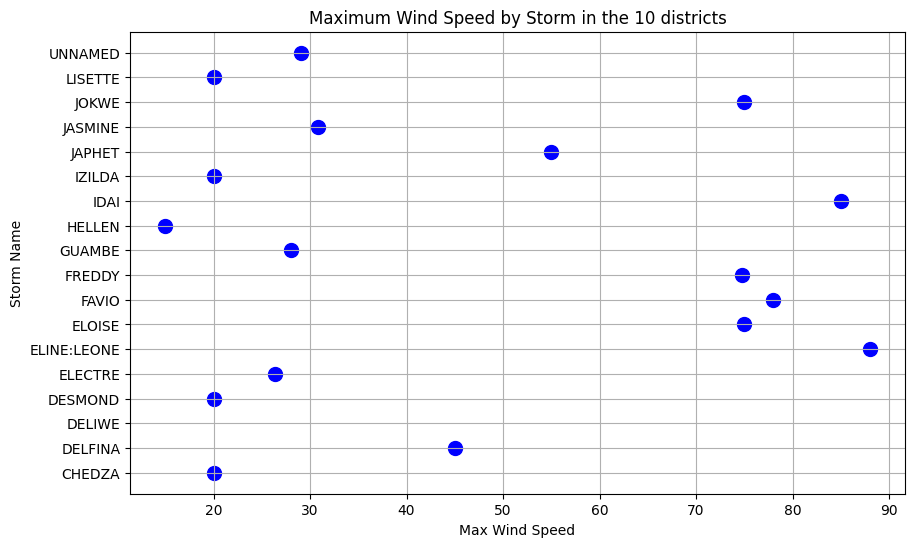

In [15]:
max_values = df_adm2.groupby("NAME")["REU_USA_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 6))
plt.scatter(
    max_values["REU_USA_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed")
plt.title("Maximum Wind Speed by Storm in the 10 districts")
plt.grid(True)
plt.show()

In [16]:
def calculate_storm_return_period(
    df, wind_speed_kmh, start_year, num_storms_year
):
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year) & (df["REU_WIND"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2022 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # Calculate return periods for each admin region
    # admin_return_periods = {}

    # grouped = df_filtered.groupby("ADM1_PT")
    # for admin, group in grouped:
    #    admin_unique_storms = group["NAME"].nunique()
    #    # admin_yr_len = max(group["year"]) - min(group["year"]) + 1
    #    admin_return_period = yr_len / admin_unique_storms
    #    admin_return_periods[admin] = admin_return_period

    #    print(
    #        f"The return period of storms over {wind_speed_kmh}km/h in {admin} is 1-in-{round(admin_return_period, 1)} years."
    #    )

    # http://hurricanepredictor.com/Methodology/USmethodology.pdf
    # Trying out the methodology above
    # using Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        * math.factorial(num_storms_year)
    )
    print(
        f"The probability of exactly {num_storms_year} making landfall in an average year is {round(expected_probability *100, 1)} %."
    )
    print(
        f"The return period of exactly {num_storms_year} making landfall in an average year is 1-in-{round(1 / expected_probability, 1)} years."
    )

In [17]:
helpers.calculate_storm_return_period(gdf_points_sel_, 130, 1980, 1)

The combined return period of storms over 89km/h is 1-in-4.3 years.
The probability of exactly 1 making landfall in an average year is 18.4 %.
The return period of exactly 1 making landfall in an average year is 1-in-5.4 years.


In [18]:
helpers.calculate_storm_return_period(
    gdf_points_sel_, THRESHOLD_SPEED_OPT2, 1980, 1
)

The combined return period of storms over 118km/h is 1-in-2.8 years.
The probability of exactly 1 making landfall in an average year is 25.1 %.
The return period of exactly 1 making landfall in an average year is 1-in-4.0 years.


In [17]:
helpers.calculate_storm_return_period(
    gdf_adm2_points,
    THRESHOLD_SPEED_OPT2,
    2000,
    1,
)

The combined return period of storms over 118km/h is 1-in-3.3 years.
Probability of 1 or more storms occurring in any given year is 0.2245.


In [18]:
helpers.calculate_storm_return_period(
    df=gdf_adm2_points,
    wind_speed_kmh=THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118km/h is 1-in-6.1 years.
Probability of 1 or more storms occurring in any given year is 0.1383.


## Looking at the historical impact of cyclones

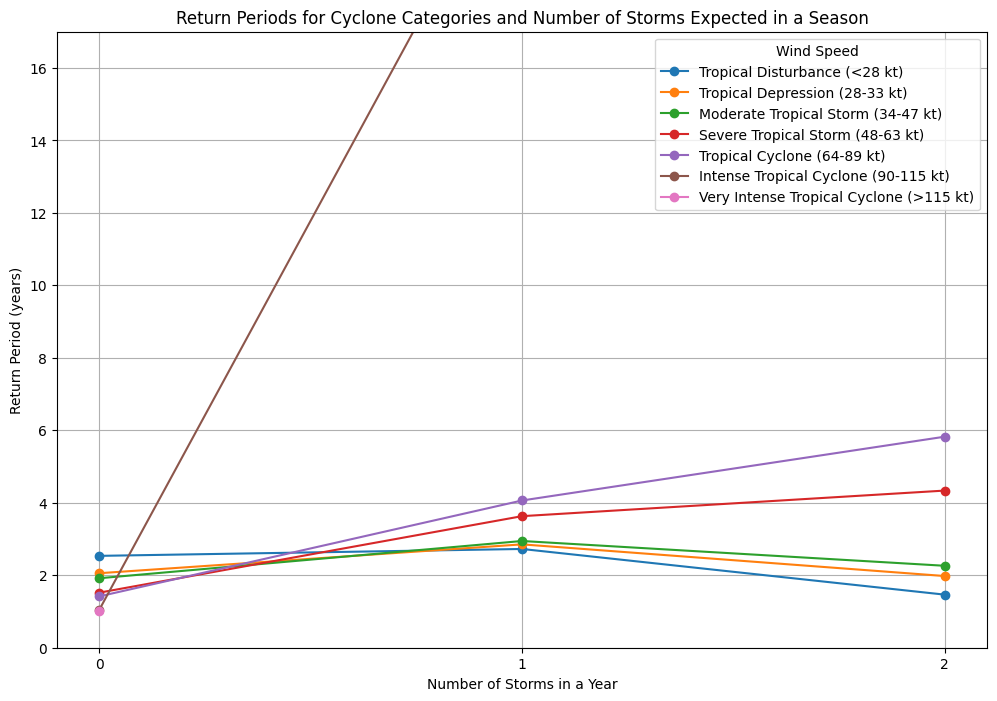

In [19]:
# Define parameters
wind_speeds = [1, 51, 63, 89, 118, 166, 212]  # List of wind speeds in km/h
storm_numbers = range(0, 3)  # Number of storms
start_year = 1980

# Prepare to plot
plt.figure(figsize=(12, 8))

# Calculate and plot return periods for each wind speed
for wind_speed in wind_speeds:
    return_periods = []
    for storm_num in storm_numbers:
        expected_probability = helpers.calculate_storm_expected_probability(
            df=gdf_points_sel_,
            wind_speed_kmh=wind_speed,
            start_year=start_year,
            num_storms_year=storm_num,
        )

        # Calculate return period from expected probability
        if expected_probability > 0:
            return_period = 1 / expected_probability
        else:
            return_period = float(
                "inf"
            )  # Handle case where probability is zero

        return_periods.append(return_period)
    label = wind_speed_categories.get(wind_speed, f"{wind_speed} km/h")
    plt.plot(storm_numbers, return_periods, marker="o", label=label)

# Add plot details
plt.xlabel("Number of Storms in a Year")
plt.ylabel("Return Period (years)")
plt.ylim(0, 17)
plt.title(
    "Return Periods for Cyclone Categories and Number of Storms Expected in a Season"
)
plt.legend(title="Wind Speed")
plt.xticks(ticks=range(min(storm_numbers), max(storm_numbers) + 1))

plt.grid(True)
plt.show()